In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

Using TensorFlow backend.


In [2]:
import os
os.getcwd()

'/home/ec2-user/SageMaker'

In [3]:
import zipfile
!unzip /home/ec2-user/SageMaker/GTSRB-Training_fixed.zip

Archive:  /home/ec2-user/SageMaker/GTSRB-Training_fixed.zip
  inflating: GTSRB/Training/00000/00000_00000.ppm  
  inflating: GTSRB/Training/00000/00000_00001.ppm  
  inflating: GTSRB/Training/00000/00000_00002.ppm  
  inflating: GTSRB/Training/00000/00000_00003.ppm  
  inflating: GTSRB/Training/00000/00000_00004.ppm  
  inflating: GTSRB/Training/00000/00000_00005.ppm  
  inflating: GTSRB/Training/00000/00000_00006.ppm  
  inflating: GTSRB/Training/00000/00000_00007.ppm  
  inflating: GTSRB/Training/00000/00000_00008.ppm  
  inflating: GTSRB/Training/00000/00000_00009.ppm  
  inflating: GTSRB/Training/00000/00000_00010.ppm  
  inflating: GTSRB/Training/00000/00000_00011.ppm  
  inflating: GTSRB/Training/00000/00000_00012.ppm  
  inflating: GTSRB/Training/00000/00000_00013.ppm  
  inflating: GTSRB/Training/00000/00000_00014.ppm  
  inflating: GTSRB/Training/00000/00000_00015.ppm  
  inflating: GTSRB/Training/00000/00000_00016.ppm  
  inflating: GTSRB/Training/00000/00000_00017.ppm  
  in

In [5]:
data = []
labels = []
classes = 43
cur_path = os.getcwd() 
print(cur_path)
#Retrieving the images and their labels 
for i in range(classes):
    path = os.path.join(cur_path,'GTSRB/Training',str(i))   #joins one or more path components
    images = os.listdir(path)                      #lists files and directories in the given path, in our case image files 
    #print(images)
    for a in images:    
        if(a.endswith('.ppm')):
          try:
            image = Image.open(path + '/'+ a)    #opens image file 
            #print(image)    
            image = image.resize((30,30))          #sizing the opened image
            image = np.array(image)                #array of images
            #sim = Image.fromarray(image) 
            data.append(image)                     #appending the data list
            labels.append(i)                      #appending the labels list
          except:
            print("Error loading image")

/home/ec2-user/SageMaker


In [6]:
#Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)
print(data.shape, labels.shape)

(26640, 30, 30, 3) (26640,)


In [7]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(21312, 30, 30, 3) (5328, 30, 30, 3) (21312,) (5328,)


In [8]:
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

In [9]:
y_train.shape, y_test.shape


((21312, 43), (5328, 43))

In [12]:
#Showing DataSet in CSV Format
train_data=pd.read_csv('/home/ec2-user/SageMaker/GTSRB/Training/0/GT-00000.csv',usecols=['ClassId','Width','Height'],)
test_data=pd.read_csv('/home/ec2-user/SageMaker/Test.csv',usecols=['ClassId','Width','Height'],)
train_data.rename({'ClassId':'label'},inplace=True,axis=1)
test_data.rename({'ClassId':'label','Path':},inplace=True,axis=1)
train_data.head()

,Width,Height,label
0,29,30,0
1,30,30,0
2,30,30,0
3,31,31,0
4,30,32,0


In [16]:
test_data.head()

,Width,Height,label
0,53,54,16
1,42,45,1
2,48,52,38
3,27,29,33
4,60,57,11


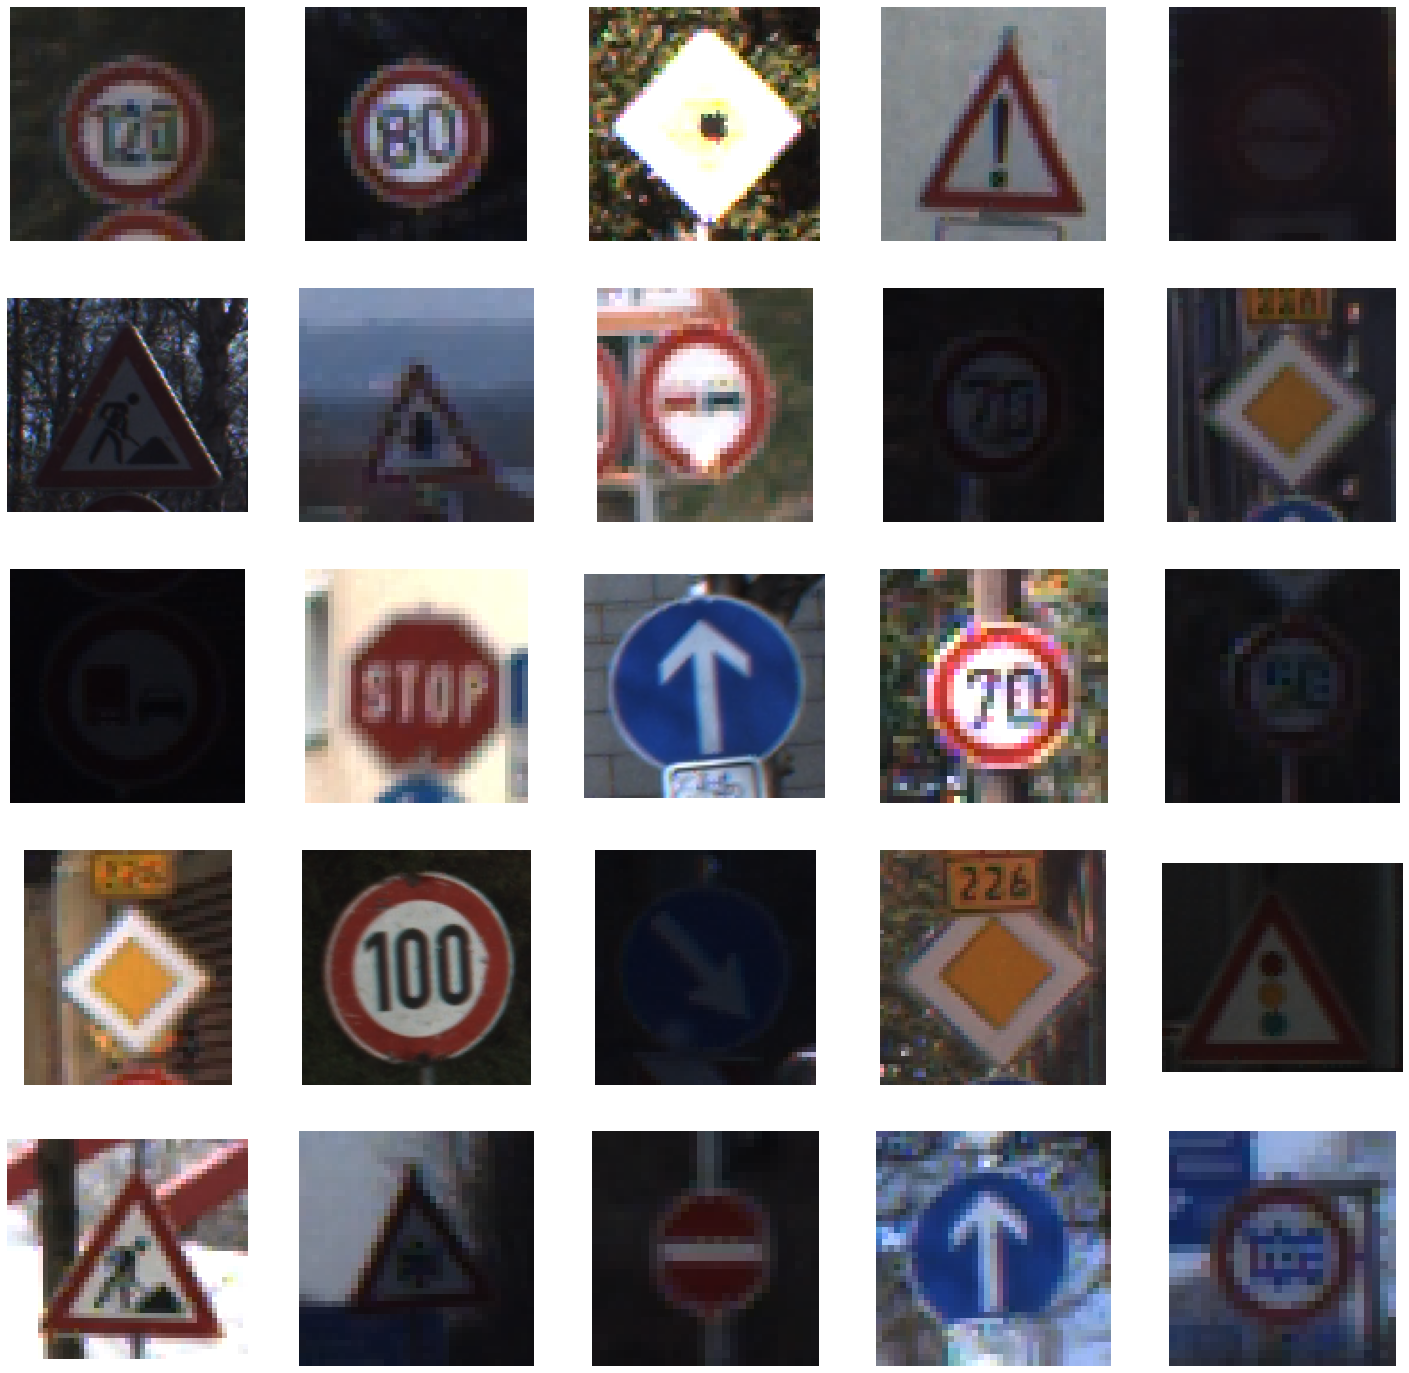

In [19]:
#visualizing Test Images
import os
import random
from matplotlib.image import imread
imgs= os.listdir('/home/ec2-user/SageMaker/GTSRB/Testing/Images')
plt.figure(figsize=(25,25))
for i in range(1,26):
    plt.subplot(5,5,i)
    random_image_path='/home/ec2-user/SageMaker/GTSRB/Testing/Images'+'/'+random.choice(imgs)
    random_image=imread(random_image_path)
    plt.imshow(random_image)
    plt.grid(b=None)
    plt.axis('off')
    plt.xlabel(random_image.shape[0],fontsize=20)
    plt.ylabel(random_image.shape[0],fontsize=20)
    
#print(imgs)

Text(0, 0.5, 'Number of images')

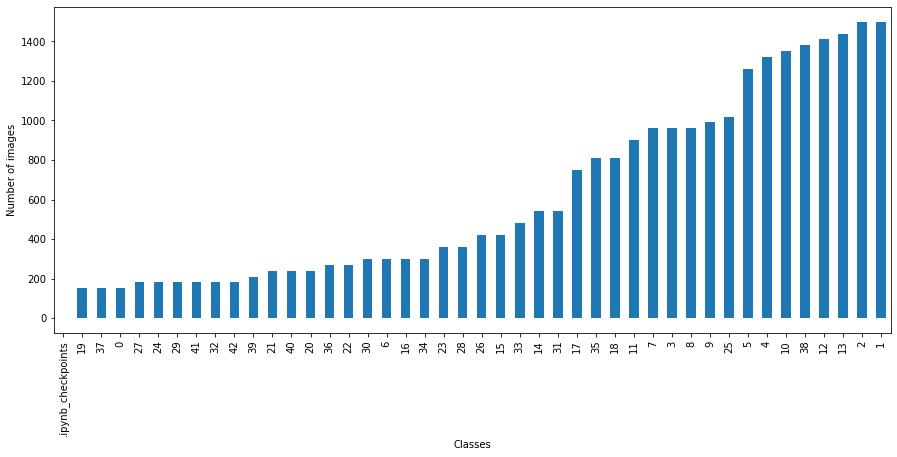

In [21]:
# Visualizing Training dat in grid and checking number of images in each class
data_dic = {}
cur_path='/home/ec2-user/SageMaker/GTSRB/Training'
for folder in os.listdir(cur_path):
    data_dic[folder] = len(os.listdir(cur_path + '/' + folder))-1

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Classes')
plt.ylabel('Number of images')

In [23]:
#Building the model
model = Sequential()

# First Layer
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Second Layer 
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))


# Dense Layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 64)         

In [25]:
!pip install visualkeras
import visualkeras

     |████████████████████████████████| 793 kB 31.1 MB/s            


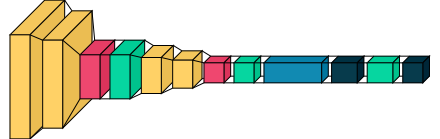

In [26]:
#visualizing the model
visualkeras.layered_view(model)

In [27]:
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 20
history = model.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_test, y_test))
model.save("My_model.h5")

Train on 21312 samples, validate on 5328 samples
Epoch 1/20
21312/21312 [==============================] - 29s 1ms/step - loss: 2.8515 - accuracy: 0.3066 - val_loss: 1.5672 - val_accuracy: 0.6139
Epoch 2/20
21312/21312 [==============================] - 27s 1ms/step - loss: 1.4613 - accuracy: 0.5742 - val_loss: 0.6477 - val_accuracy: 0.8309
Epoch 3/20
21312/21312 [==============================] - 27s 1ms/step - loss: 0.9599 - accuracy: 0.7099 - val_loss: 0.4694 - val_accuracy: 0.8669
Epoch 4/20
21312/21312 [==============================] - 27s 1ms/step - loss: 0.6982 - accuracy: 0.7880 - val_loss: 0.2804 - val_accuracy: 0.9180
Epoch 5/20
21312/21312 [==============================] - 29s 1ms/step - loss: 0.5259 - accuracy: 0.8410 - val_loss: 0.1846 - val_accuracy: 0.9521
Epoch 6/20
21312/21312 [==============================] - 27s 1ms/step - loss: 0.4124 - accuracy: 0.8763 - val_loss: 0.1249 - val_accuracy: 0.9655
Epoch 7/20
21312/21312 [==============================] - 27s 1ms/ste

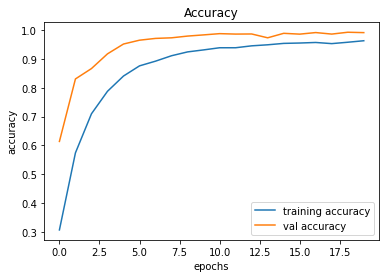

In [28]:
#plotting accuracy graphs 
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

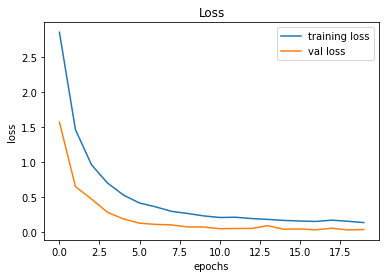

In [29]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [30]:
# Evaluation Score
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss', score[0])
print('Test accuracy', score[1])

Test Loss 0.03439293251232686
Test accuracy 0.9917417168617249


In [32]:
y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)
#print(y_test_class,y_pred_class)

[11  8  1 ... 13 40 38] [11  8  1 ... 13 40 38]


In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        27
           1       0.99      0.98      0.98       291
           2       0.98      1.00      0.99       313
           3       1.00      0.99      0.99       212
           4       0.98      1.00      0.99       262
           5       0.99      0.97      0.98       261
           6       1.00      0.98      0.99        58
           7       1.00      0.97      0.99       191
           8       0.98      0.99      0.99       200
           9       1.00      0.99      1.00       203
          10       1.00      1.00      1.00       257
          11       0.99      0.99      0.99       176
          12       1.00      1.00      1.00       298
          13       0.99      1.00      1.00       310
          14       0.99      1.00      1.00       101
          15       0.95      1.00      0.97        86
          16       0.98      1.00      0.99        52
          17       1.00    

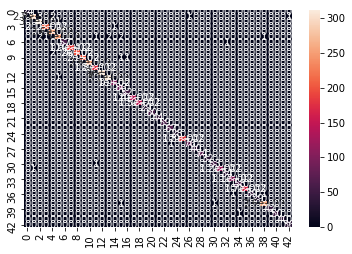

In [35]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_class, y_pred_class)
import seaborn as sns
sns.heatmap(cm,annot=True)
plt.savefig('Matrix.png')

In [36]:
# Calculation of Accuracy
from sklearn.metrics import accuracy_score
score=accuracy_score(y_pred_class,y_test_class)
print(score)

0.9917417417417418


In [37]:
model.save('Trafficsign_detector.h5')